In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import gc
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree

warnings.filterwarnings('ignore')

In [45]:
# Set the path to the Excel file containing survey results
survey_results_path = r'SurveyResults.xlsx'

# Read the survey results from Excel and process date-time columns
survey_data = pd.read_excel(survey_results_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_data['Stress level'].replace('na', np.nan, inplace=True)
survey_data.dropna(inplace=True)

survey_data['Start datetime'] = pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['Start time'].map(str))
survey_data['End datetime'] = pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['End time'].map(str))
survey_data.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

# Split survey data into two parts based on daylight saving time
survey_data_part1 = survey_data[survey_data['End datetime'] <= daylight].copy()
survey_data_part1['Start datetime'] = survey_data_part1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_data_part1['End datetime'] = survey_data_part1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_data_part2 = survey_data.loc[survey_data['End datetime'] > daylight].copy()
survey_data_part2['Start datetime'] = survey_data_part2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_data_part2['End datetime'] = survey_data_part2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_data = pd.concat([survey_data_part1, survey_data_part2], ignore_index=True)
survey_data['duration'] = survey_data['End datetime'] - survey_data['Start datetime']

# Define a function to calculate duration in minutes
def calculate_duration_minutes(duration):
    return duration.seconds / 60

survey_data['duration_minutes'] = survey_data['duration'].apply(calculate_duration_minutes)

survey_data.reset_index(drop=True, inplace=True)

In [53]:
# Function to process DataFrame with timestamp
def process_df_with_timestamp(df):
    start_timestamp = df.iloc[0, 0]
    sample_rate = df.iloc[1, 0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
    new_df['datetime'] = [(start_timestamp + i / sample_rate) for i in range(len(new_df))]
    return new_df

def read_zipfile(filepath):
    print(filepath)
    with zipfile.ZipFile(filepath) as zf:
        zf.extractall()
        acc = pd.read_csv('ACC.csv', index_col=None, header=0)
        blood_vol = pd.read_csv('BVP.csv', index_col=None, header=0)
        eda = pd.read_csv('EDA.csv', index_col=None, header=0)
        heart_rate = pd.read_csv('HR.csv', index_col=None, header=0)
        temp = pd.read_csv('TEMP.csv', index_col=None, header=0)

        acc = acc.rename(columns={acc.columns[0]: 'acc_X', acc.columns[1]: 'acc_Y', acc.columns[2]: 'acc_Z'})
        blood_vol = blood_vol.rename(columns={blood_vol.columns[0]: 'blood_volume'})
        eda = eda.rename(columns={eda.columns[0]: 'EDA'})
        heart_rate = heart_rate.rename(columns={heart_rate.columns[0]: 'HR'})      
        temp = temp.rename(columns={temp.columns[0]: 'TEMP'})
        
        acc = process_df_with_timestamp(acc)
        blood_vol = process_df_with_timestamp(blood_vol)
        eda = process_df_with_timestamp(eda)
        heart_rate = process_df_with_timestamp(heart_rate)
        temp = process_df_with_timestamp(temp)

        # Merge the DataFrames
        joined = acc.merge(eda, on='datetime', how='outer')
        joined = joined.merge(bloos_vol, on='datetime', how='outer')
        joined = joined.merge(heart_rate, on='datetime', how='outer')
        joined = joined.merge(temp, on='datetime', how='outer')
            
        joined.fillna(method = 'ffill', inplace = True)
        joined.fillna(method = 'ffill', inplace = True)
        joined = joined.reset_index(drop = True)
        
        os.remove('ACC.csv')
        os.remove('BVP.csv')
        os.remove('EDA.csv')
        os.remove('HR.csv')
        os.remove('TEMP.csv')
        return joined
        
        gc.collect()

folders = glob.glob(os.path.join("Stress_dataset", "*"))
files = [glob.glob(os.path.join(f, '*.zip')) for f in folders]
dfs = [read_zipfile(file) for sublist in files for file in sublist]
df = pd.concat(dfs, ignore_index=True, sort=False)

In [46]:
# Convert the 'datetime' column in 'final_data' to datetime64 type
data['datetime'] = pd.to_datetime(data['datetime'])

# Convert the 'id' column in 'final_data' and 'ID' column in 'survey_data' to string data type
data['id'] = data['id'].astype(str)

# Define a function to label rows in 'final_data' as 1 or 0 based on the 'datetime' column
def label_data(row_datetime):
    max_datetime = survey_data['End datetime'].max()
    if row_datetime >= max_datetime:
        return 1
    else:
        return 0

# Apply the 'label_data' function to the 'datetime' column in 'final_data' and assign the result to a new 'Label' column
data['Label'] = data['datetime'].apply(label_data)
df = data.copy()

df.to_csv('Preprocessed_data.csv')

In [42]:
data = data.rename(columns={data.columns[0]: 'acc_x', data.columns[1]: 'acc_y', data.columns[2]: 'acc_z'})
data = data.rename(columns={data.columns[6]: 'blood_volume'})
data = data.rename(columns={data.columns[5]: 'EDA'})
data = data.rename(columns={data.columns[8]: 'HR'})      
data = data.rename(columns={data.columns[7]: 'TEMP'})

# -------------------------------------

In [41]:
data = pd.read_csv('Preprocessed_data.csv')
data.drop('Unnamed: 0',axis = 1,inplace = True)

In [12]:
data.head()

,acc_x,acc_y,acc_z,id,datetime,EDA,blood_volume,TEMP,HR,Label
0,-27.0,4.0,56.0,15,32.000000,0.185782,-0.0,31.11,95.98,0
1,-26.0,4.0,57.0,15,31.969697,0.185782,-0.0,31.11,95.98,0
2,-32.0,1.0,59.0,15,31.939394,0.185782,-0.0,31.11,95.98,0
3,-37.0,0.0,57.0,15,31.909091,0.185782,-0.0,31.11,95.98,0
4,-37.0,-1.0,54.0,15,31.878788,0.185782,-0.0,31.11,95.98,0


In [13]:
data.dtypes

acc_x           float64
acc_y           float64
acc_z           float64
id                int64
datetime        float64
EDA             float64
blood_volume    float64
TEMP            float64
HR              float64
Label             int64
dtype: object

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27564635 entries, 0 to 27564634
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   acc_x         float64
 1   acc_y         float64
 2   acc_z         float64
 3   id            int64  
 4   datetime      float64
 5   EDA           float64
 6   blood_volume  float64
 7   TEMP          float64
 8   HR            float64
 9   Label         int64  
dtypes: float64(8), int64(2)
memory usage: 2.1 GB


In [15]:
#Check any null value (checking still cause filled backward and forwardfill before)
data.isnull().sum()

acc_x           0
acc_y           0
acc_z           0
id              0
datetime        0
EDA             0
blood_volume    0
TEMP            0
HR              0
Label           0
dtype: int64

# Check Imbalance Data

In [16]:
#Data is imbalanced
data['Label'].value_counts()

0    25736530
1     1828105
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

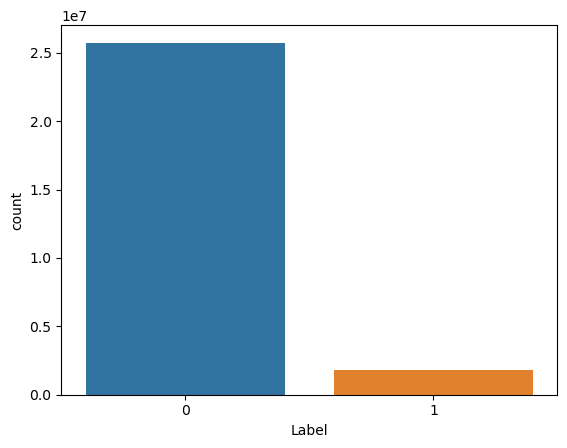

In [43]:
sns.countplot(data['Label'])

# Resampling

In [18]:
#The code combines the zero_values and one_values DataFrames using the pd.concat method, generating a fresh DataFrame for upsampling.
#By setting the ignore_index argument to True, the concatenated DataFrame's index is reset. This ensures a new DataFrame with approximately
#balanced counts of rows, where the target column values are 0 or 1.


X = data.drop({'Label','datetime'},axis = 1)
Y = data['Label']   
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=100)

sm = SMOTE()   
dependent, label = sm.fit_resample(X_train, y_train.ravel())
print("UpSampling 1:- {}".format(sum(label==1)))

data = dependent.copy()
data['Label'] = label

UpSampling 1:- 19303443


In [20]:
#Balanced Data 1 to 0 ratio
data['Label'].value_counts()

0    19303443
1    19303443
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

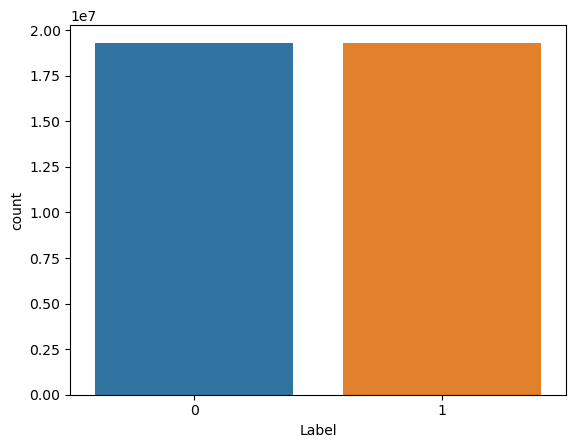

In [21]:
sns.countplot(data['Label'])

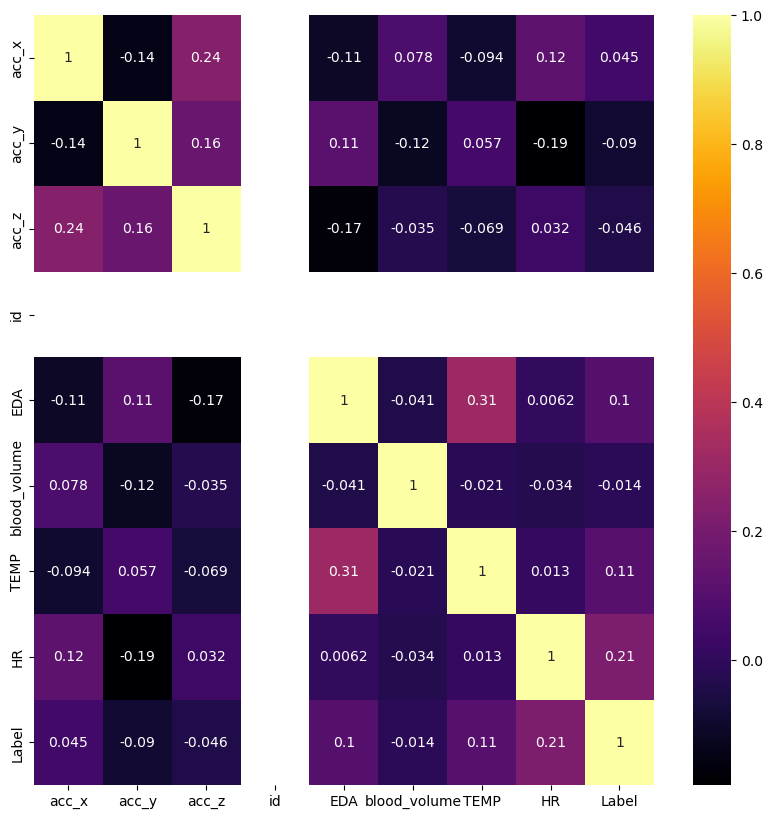

In [24]:
"""
A heatmap is utilized to visually represent the correlation between different variables in a dataset. 
It employs a color spectrum to indicate the strength and direction of correlations. Warmer colors denote 
positive correlations, while cooler colors signify negative correlations. Heatmaps offer a comprehensive view 
of how variables relate to each other, enabling quick identification of patterns and relationships within complex datasets. 
They are commonly used in exploratory data analysis, feature selection, and model building to understand multicollinearity, 
identify influential variables, and guide decision-making in data-driven tasks."""

fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(data.corr().transpose(), cmap='inferno',annot = True)
plt.show()

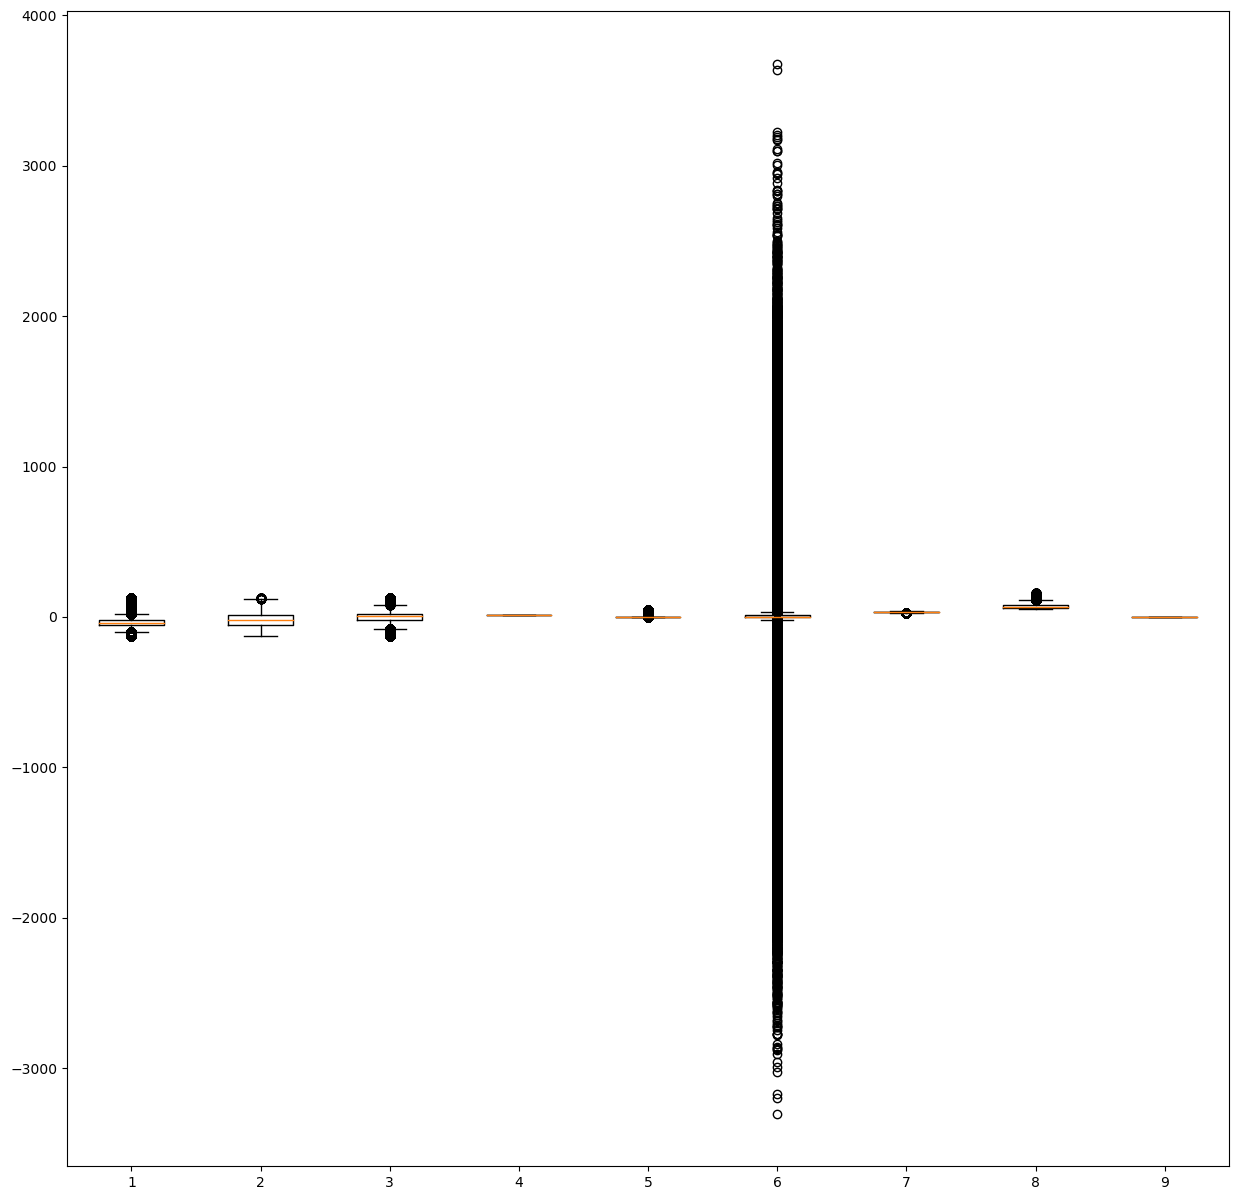

In [25]:
"""Box plots are valuable for identifying data distribution characteristics, detecting skewness, and assessing the 
presence of outliers. They are commonly used in exploratory data analysis to gain insights into the spread and 
variability of data, aiding in decision-making and hypothesis generation"""

fig, ax = plt.subplots(figsize=(15,15))
plt.boxplot(data)
plt.show()

array([[<AxesSubplot:title={'center':'acc_x'}>,
        <AxesSubplot:title={'center':'acc_y'}>,
        <AxesSubplot:title={'center':'acc_z'}>],
       [<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'EDA'}>,
        <AxesSubplot:title={'center':'blood_volume'}>],
       [<AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'HR'}>,
        <AxesSubplot:title={'center':'Label'}>]], dtype=object)

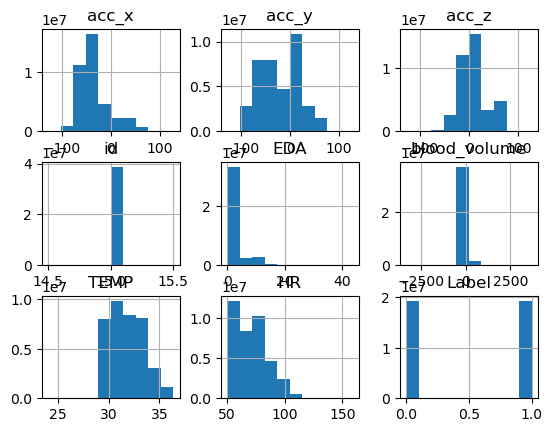

In [26]:
data.hist()

# Time series Representation of the data

In [28]:
"""Time series plots are essential tools in time-based data analysis, aiding in understanding historical patterns, 
making predictions, and informing decision-making. They are particularly useful for forecasting future trends and assessing 
the impact of certain events on the variable being studied."""

'Time series plots are essential tools in time-based data analysis, aiding in understanding historical patterns, \nmaking predictions, and informing decision-making. They are particularly useful for forecasting future trends and assessing \nthe impact of certain events on the variable being studied.'

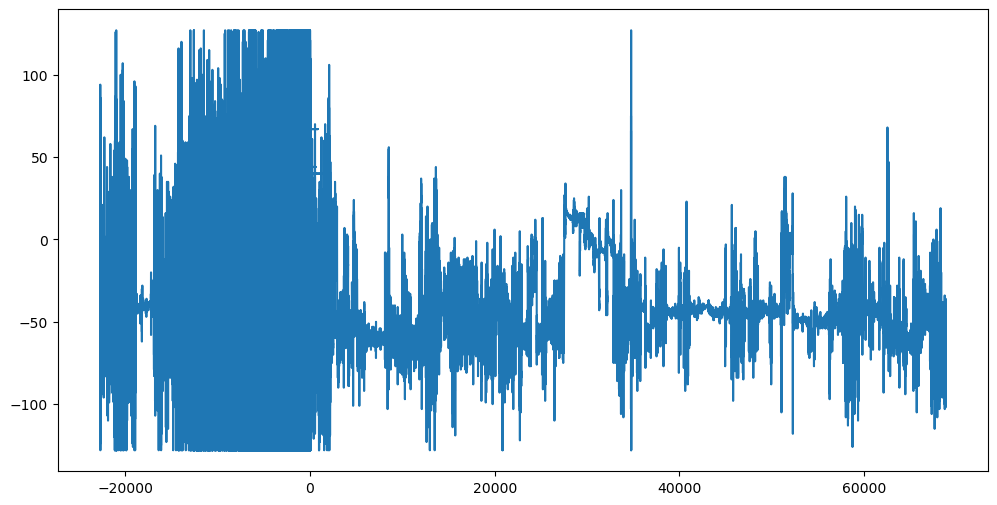

In [47]:
plt.figure(figsize=(12, 6))
print(plt.plot(data.datetime,data.acc_x))

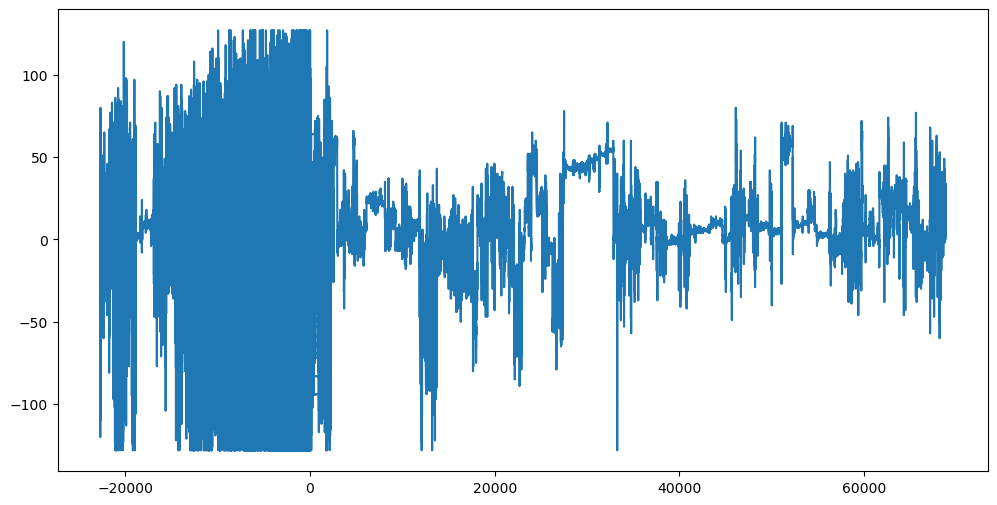

In [48]:
plt.figure(figsize=(12, 6))
print(plt.plot(data.datetime,data.acc_y))

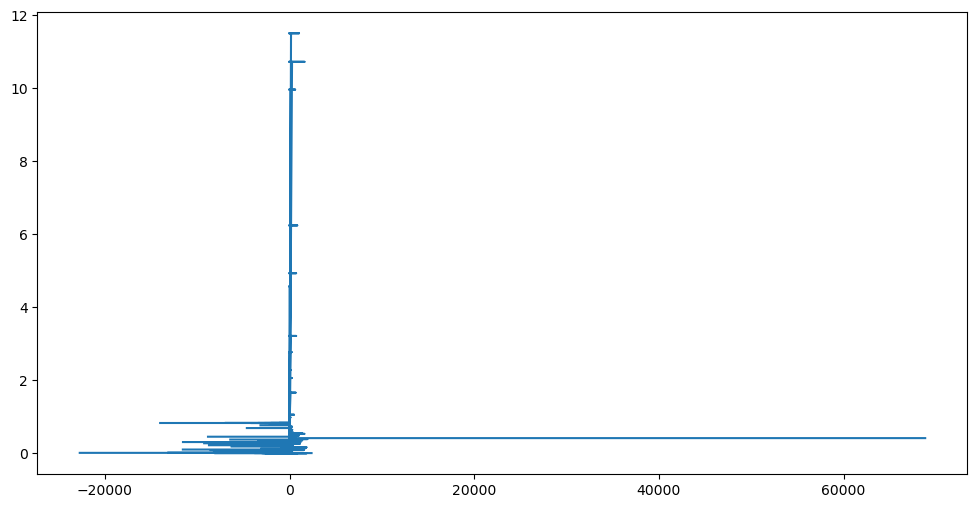

In [49]:
plt.figure(figsize=(12, 6))
print(plt.plot(data.datetime,data.EDA))

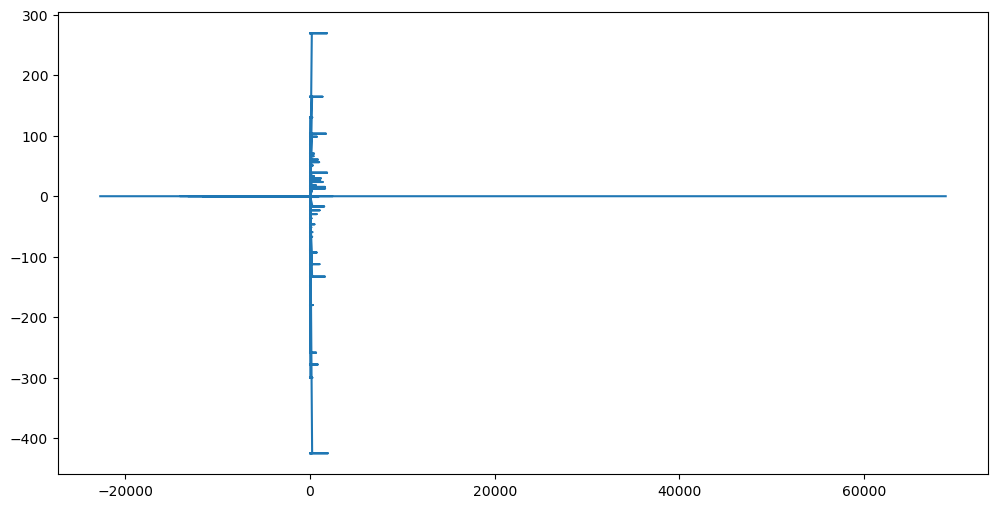

In [50]:
plt.figure(figsize=(12, 6))
print(plt.plot(data.datetime,data.blood_volume))

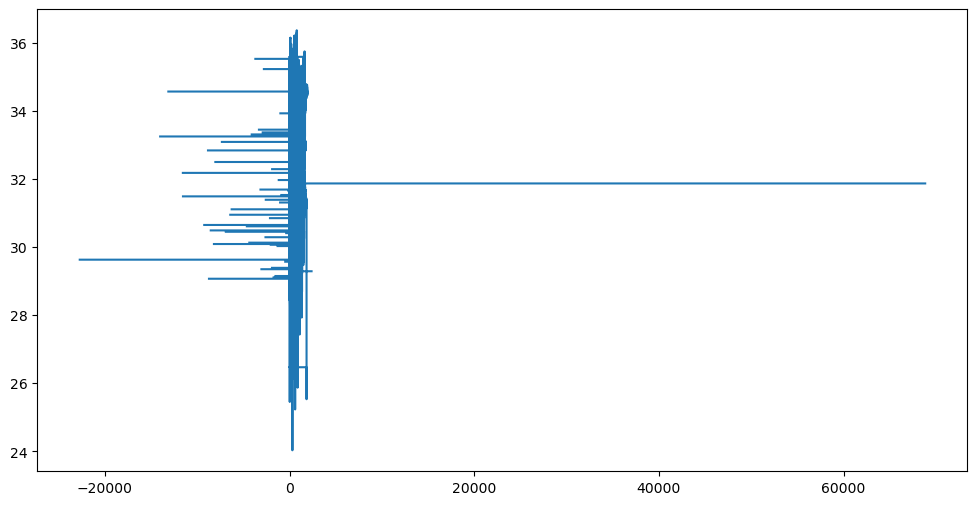

In [51]:
plt.figure(figsize=(12, 6))
print(plt.plot(data.datetime,data.TEMP))

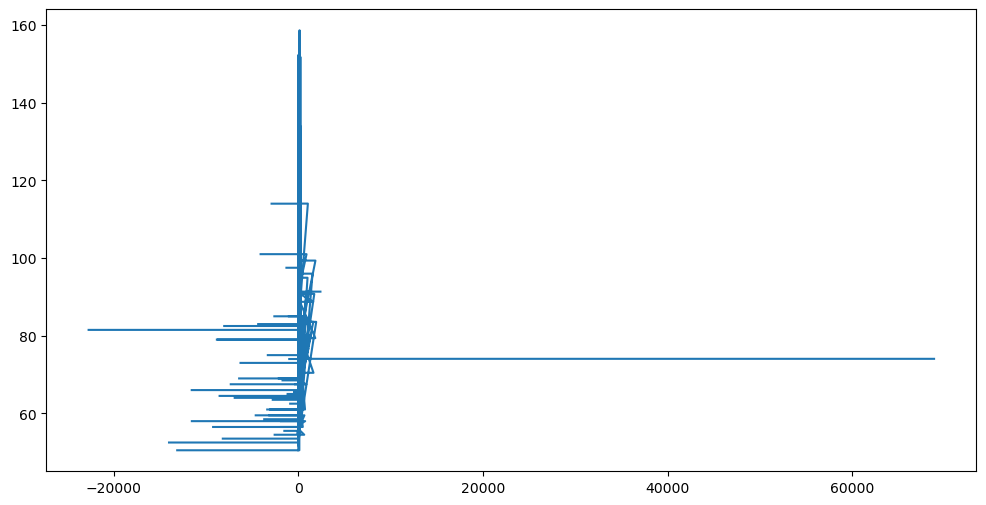

In [52]:
plt.figure(figsize=(12, 6))
print(plt.plot(data.datetime,data.HR))

# SPLIT DATA INTO TRAINING AND TESTING 70% and 30%

In [30]:
training = data.iloc[:int(data.shape[0] * 0.70)]
testing = data.iloc[int(data.shape[0] * 0.70):]

X_train = training.drop({'Label','id'}, axis=1)
y_train = training['Label']
X_test = testing.drop({'Label','id'}, axis=1)
y_test = testing['Label']

In [31]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(27024820, 7) (27024820,) (11582066, 7) (11582066,)


# NORMILIZATION

In [33]:
X_train_features = X_train
X_test_features = X_test

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# MODEL IMPLEMENTATION

# LOGISTIC REGRESSION

In [38]:
clf = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [34]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support
                                                      
           0        0.64      0.69      0.68   11582066
           1        0.69      0.64      0.68   11582066
                                          68          
    accuracy                            0.68   27024820
   macro avg        0.68      0.68      0.68   27024820
weighted avg        0.68      0.68      0.68   27024820


# RANDOM FOREST

In [39]:
RF = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred = RF.predict(X_test_scaled)

In [36]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support
                                                      
           0        0.93      0.91      0.92   11582066
           1        0.91      0.93      0.92   11582066
                                                     
    accuracy                            0.92   27024820
   macro avg        0.92      0.92      0.92   27024820
weighted avg        0.92      0.92      0.92   27024820


# DECISION TREE 

In [40]:
clf = tree.DecisionTreeClassifier().fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

In [37]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support
                                                      
           0        0.56      0.63      0.58   11582066
           1        0.63      0.56      0.58   11582066
                                                     
    accuracy                            0.58   27024820
   macro avg        0.58      0.58      0.58   27024820
weighted avg        0.58      0.58      0.58   27024820
